# Emma and Michael's Dank Boio Modeling and Simulation in Python (Copyright Allen B. Downey) Project Number 3 in the Eleventh Month of the Two Thousand and Eighteenth Year

In [176]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *
import math as math

In [177]:
x_0 = 362600000 # 362,600 km at perigee
v_0 = 1078.2 # 1078.2 m/s at perigee
Me_0 = 5.9722e24 # 5.9722×10^24 kg
Mm_0 = 7.342e22 # 7.342×10^22 kg

init = State(Me = Me_0, # Initial mass of earth
             Mm = Mm_0, #Initial mass of moon
             x=x_0, # 362,600 km at perigee
             y=0,
             vx=0,
             vy=v_0 # 1078.2 m/s at perigee
            )


,values
Me,5.972200e+24
Mm,7.342000e+22
x,3.626000e+08
y,0.000000e+00
vx,0.000000e+00
vy,1.078200e+03


In [178]:
def earth_radius(mass):
    density = 5514 # 5514 kg/m3 from NASA Earth Fact Sheet
    Re = (3*mass / (4*pi*density))**(1/3)
    return Re
def moon_radius(mass):
    density = 3344 # 3344 kg/m3 from NASA Moon Fact Sheet
    Rm = (3*mass / (4*pi*density))**(1/3)
    return Rm

system = System(init=init,
                dmdt = 1.5e17, #kg/s,
                r_e = earth_radius,
                r_m = moon_radius,
                G=6.674e-11, #N / kg**2 * m**2
                t_0=0,
                t_end=100*365*24*60*60) 

,values
init,Me 5.972200e+24 Mm 7.342000e+22 x 3....
dmdt,1.5e+17
r_e,<function earth_radius at 0x000001DD01232C80>
r_m,<function moon_radius at 0x000001DD01390D08>
G,6.674e-11
t_0,0
t_end,3153600000


In [179]:
def net_force(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    Me,Mm,x,y,vx,vy = state
    unpack(system)
    
    #Gravitational Force
    r = sqrt(x**2 + y**2)
    v = sqrt(vx**2 + vy**2)
    force= G * Me * Mm / r**2
    direction = math.atan2(y,x) + pi 
    gravitational_force = Vector(force * math.cos(direction), force*math.sin(direction) )
    
    # Moon momentum contribution
    collision_force = dmdt * -(Vector(vx,vy))
    
    return gravitational_force + collision_force

In [180]:
net_force(init, system)

<Quantity([-2.22576509e+20 -1.61730000e+20], 'dimensionless')>

In [181]:
def slope_func(state,t,system):
    
    Me,Mm,x,y,vx,vy = state
    unpack(system)
    V = Vector(vx,vy)
    
    Fnet = net_force(state,system)
    
    dMedt = -dmdt
    dMmdt = dmdt
    dxdt = V
    dvdt = Fnet / Mm
    
    return dMedt, dMmdt, dxdt[0], dxdt[1], dvdt[0],dvdt[1]

In [182]:
slope_func(init, 0, system)

(-1.5e+17,
 1.5e+17,
 <Quantity(0.0, 'dimensionless')>,
 <Quantity(1078.2, 'dimensionless')>,
 <Quantity(-0.0030315514688456138, 'dimensionless')>,
 <Quantity(-0.0022028057749931894, 'dimensionless')>)

In [183]:
def event_func(state,t,system):
    Me,Mm,x,y,vx,vy = state
    unpack(system)
   
    r = sqrt(x**2 + y**2)
    r_collision = earth_radius(Me) + moon_radius(Mm)
    
    return r - r_collision

In [184]:
event_func(init,0,system)

354492134.3300541

In [189]:
results, details = run_ode_solver(system, slope_func,events=event_func,  method="RK23")
details

,values
sol,None
t_events,[[2305161.9310121797]]
nfev,3113
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [190]:
results.index /= 24*60*60
results

,Me,Mm,x,y,vx,vy
0.000000e+00,5.972200e+24,7.342000e+22,3.626000e+08,0.000000e+00,0.000000e+00,1078.200000
2.146925e-11,5.972200e+24,7.342000e+22,3.626000e+08,2.000000e-03,-5.623355e-09,1078.200000
2.361617e-10,5.972200e+24,7.342000e+22,3.626000e+08,2.199999e-02,-6.185691e-08,1078.200000
2.383086e-09,5.972200e+24,7.342000e+22,3.626000e+08,2.219999e-01,-6.241924e-07,1078.200000
2.385233e-08,5.972200e+24,7.342000e+22,3.626000e+08,2.221999e+00,-6.247548e-06,1078.199995
2.385448e-07,5.972200e+24,7.342000e+22,3.626000e+08,2.222199e+01,-6.248110e-05,1078.199955
2.385470e-06,5.972200e+24,7.342003e+22,3.626000e+08,2.222219e+02,-6.248165e-04,1078.199546
2.385472e-05,5.972200e+24,7.342031e+22,3.626000e+08,2.222217e+03,-6.248158e-03,1078.195460
2.385472e-04,5.972197e+24,7.342309e+22,3.626000e+08,2.222175e+04,-6.248039e-02,1078.154599
2.385472e-03,5.972169e+24,7.345092e+22,3.625999e+08,2.221754e+05,-6.246841e-01,1077.745991


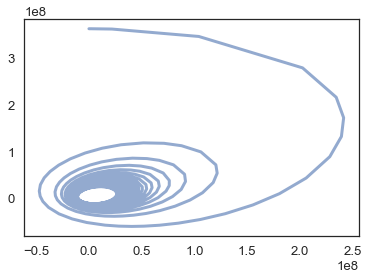

In [187]:
plot(results.y,results.x)